# Mesh design for AWAKEN Neutral case

In [1]:
%%capture

# Change some display properties
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Important header information
naluhelperdir = '/autofs/nccs-svm1_proj/cfd162/lcheung/NaluWindHelperScripts'
# Import libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
sys.path.insert(1, naluhelperdir)
import plotmesh

# Colors for refinement levels
colors=plotmesh.meshcolors

sampleplanesavefile='sampleplanesprecursor_neutral.yaml'
meshfile='meshdesign.yaml'

%matplotlib inline

In [2]:
# Get the overall domain location & size
domainsize   = [ 5120,   5120,   960]   # Domain size in meters
dx           = [  10.0,    10.0, 10.0]   # Background mesh size
farmcenter   = [ 2000,   2560] 
rotorD       = 127.0
turbHH       = 90.0

# Put the locations of the turbines here
turbinelocs  = """
      - [ 2000.0, 2560, 0.0 ]
      #- [ 2000.0, 2020.25, 0.0 ]
"""

savefiles    = True
precursoryaml       = 'precursormesh_neutral.yaml'
turbineyaml         = 'turbinemesh_neutral.yaml'
sampleplanesavefile = 'sampleplanes_neutral.yaml'

### Background mesh

In [3]:
# This is for the background mesh
nalutemplate = """
nalu_abl_mesh:
  output_db: mesh_abl.exo
  spec_type: bounding_box
  fluid_part_name: fluid_part
  vertices:
  - [0.0, 0.0, 0.0]
  - [%f, %f, %f] 

  mesh_dimensions: [%i, %i, %i] 
  xmin_boundary_name: west
  xmax_boundary_name: east
  ymin_boundary_name: south
  ymax_boundary_name: north
  zmin_boundary_name: lower
  zmax_boundary_name: upper

# Mandatory section for Nalu preprocessing
nalu_preprocess:
  # Name of the input exodus database
  input_db: mesh_abl.exo
  # Name of the output exodus database
  output_db: precursorbase.exo

  # Nalu preprocessor expects a list of tasks to be performed on the mesh and
  # field data structures
  tasks:
    - mesh_local_refinement

  mesh_local_refinement:
    fluid_parts: [fluid_part]
    write_percept_files: true
    percept_file_prefix: adapt
    search_tolerance: 21.0

    turbine_locations:
      - [ %f, %f, 0.0 ]

    turbine_diameters: %f          # Provide a list for variable diameters
    turbine_heights: %f            # Provide a list for variable tower heights
    orientation:
      type: wind_direction
      wind_direction:  270.0 
    refinement_levels:  
    # Upstream, downstream, lateral, and vertical heights in turbine D
      - [10, 17, 6, 4 ]    # level 1 (5m mesh)
      - [5,  15, 2.5, 1.2 ]     # level 2 (2.5m mesh)
#      - [30, 20, 5,  4 ]     # level 3 (1.25m mesh)
#      - [2.5,2.5,2.5,2 ]     # level 4 (0.625m mesh)

"""
naluinput=nalutemplate%(domainsize[0], domainsize[1], domainsize[2], 
                        int(domainsize[0]/float(dx[0])), int(domainsize[1]/float(dx[1])), int(domainsize[2]/float(dx[2])),
                        farmcenter[0], farmcenter[1],
                        rotorD, turbHH)

if savefiles:
    f = open(precursoryaml,'w')
    f.write(naluinput)
    f.close()

### Turbine refinement

In [4]:
# This is for the background mesh
naluturbinetemplate = """
# Mandatory section for Nalu preprocessing
nalu_preprocess:
  # Name of the input exodus database
  input_db: precursormesh.exo
  # Name of the output exodus database
  output_db: turbinemesh.exo

  # Nalu preprocessor expects a list of tasks to be performed on the mesh and
  # field data structures
  tasks:
    - mesh_local_refinement

  mesh_local_refinement:
    fluid_parts: [fluid_part]
    write_percept_files: true
    percept_file_prefix: adapt
    search_tolerance: 11.0

    turbine_locations:
    %s

    turbine_diameters: %f          # Provide a list for variable diameters
    turbine_heights: %f            # Provide a list for variable tower heights
    orientation:
      type: wind_direction
      wind_direction:  270.0 
    refinement_levels:  
    # Upstream, downstream, lateral, and vertical heights in turbine D
      - [ 1, 1,     0.6,    1 ]    # level 4 (0.3125m)

#      - [ 3, 2,     1.0,  1.2 ]    # level 2
#      - [ 2, 1.25,  0.75, 0.8 ]    # level 3
#      - [0.5,0.5,   0.6,  0.5 ]    # level 4
"""
naluturbines=naluturbinetemplate%(turbinelocs, rotorD, turbHH)

#if savefiles:
#    f = open(turbineyaml,'w')
#    f.write(naluturbines)
#    f.close()

### Plot meshes and get estimated mesh size

2
[[25165824, [10.0, 10.0, 10.0]], [62188160, [5.0, 5.0, 5.0]], [89542944, [2.5, 2.5, 2.5]]]


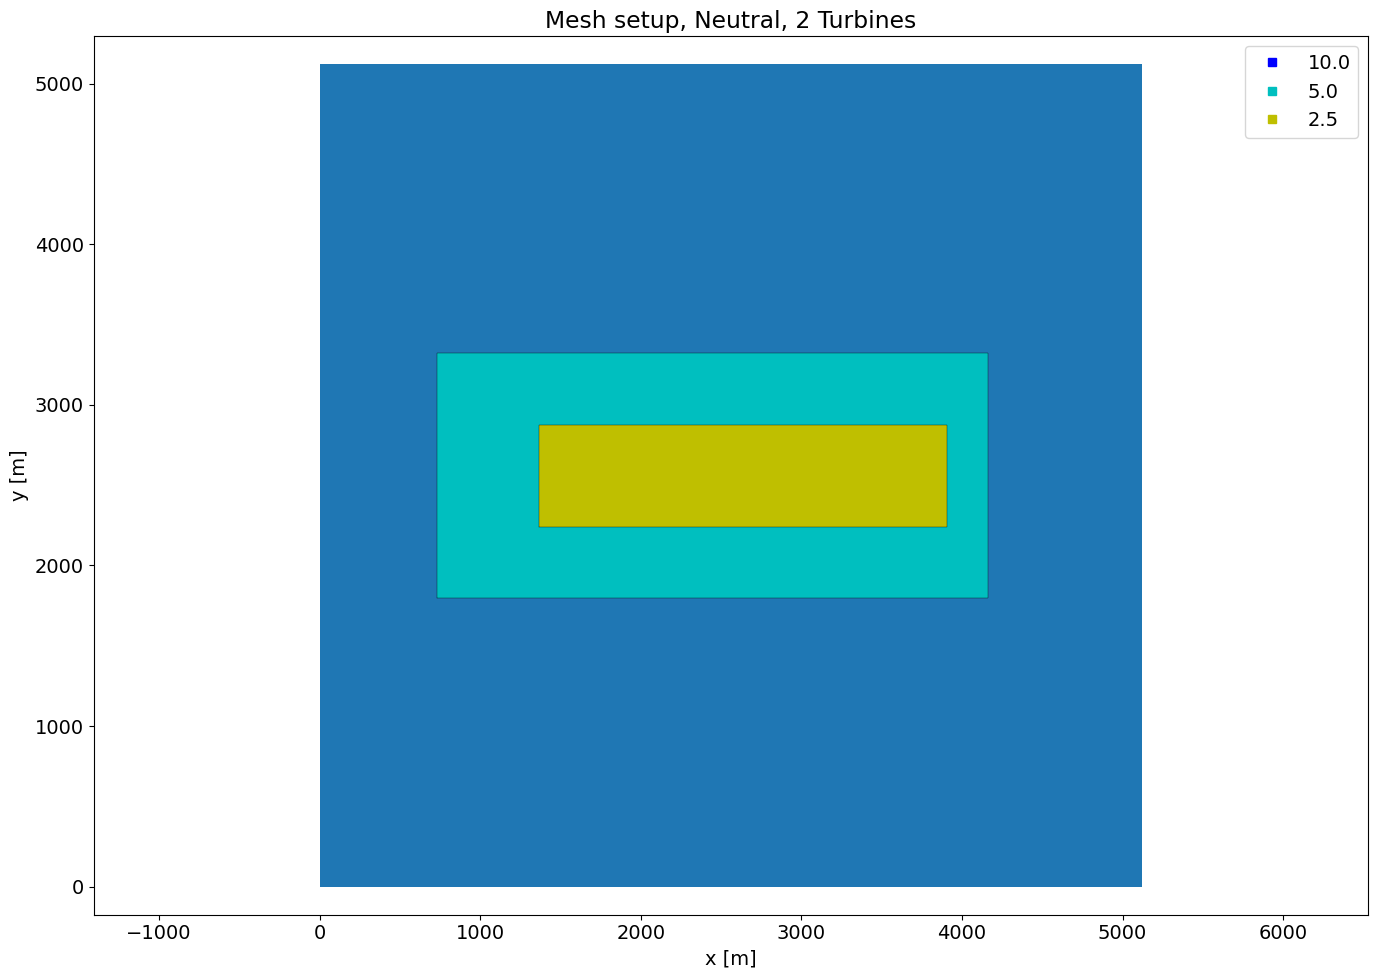

In [5]:
plt.figure(figsize=(14,10));
#fig, axs = plt.subplots(1,2,figsize=(14,7),sharey=False);
plt.rc('font', size=14)

norththeta = (180.0-270.0)*np.pi/180.0
northvec   = [-np.sin(norththeta), np.cos(norththeta)]

# Plot the background mesh
yamldata = plotmesh.getyamlfromstring(naluinput)
turbineXY, turbineD, turbineHH, orienttype, winddir, refineboxes = plotmesh.getPreprocess(yamldata)
plotmesh.plotmeshes(yamldata, turbineXY, turbineD, winddir, refineboxes, windarrowcenter=None, initlevel=1, plotturbs=False)

# Plot the individual turbine mesh
ilevel = len(refineboxes)
print(ilevel)
#yamldata2= plotmesh.getyamlfromstring(naluturbines)
#turbineXY2, turbineD, turbineHH, orienttype, winddir, refineboxes2 = plotmesh.getPreprocess(yamldata2)
#plotmesh.plotmeshes(yamldata2, turbineXY2, turbineD, winddir, refineboxes2, windarrowcenter=None, initlevel=ilevel+1)


zoomin = False   # If True, zoom in on the turbines
if zoomin:
    plt.xlim([1800, 2200])
    plt.ylim([1800, 2200])
else:
    plt.axis('equal');

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Mesh setup, Neutral, 2 Turbines');

sizelevelsmin0 = plotmesh.estimateMeshSize(yamldata, turbineXY, turbineD, winddir, refineboxes, weights=[1,1])
print(sizelevelsmin0)
#sizelevelsmin  = plotmesh.estimateMeshSize(yamldata2, turbineXY2, turbineD, winddir, refineboxes2, 
#                                           initsizes=sizelevelsmin0, startlevel=ilevel, weights=[1,1])

# Make a legend
legend_el = []
for i, level in enumerate(sizelevelsmin0): legend_el.append(Line2D([0],[0], linewidth=0, marker='s',color=colors[i], label=level[1][0]))
plt.legend(handles=legend_el, fontsize=14, frameon=True)
plt.tight_layout()

In [6]:
# Get the mesh size
sizelevelsmin0 = plotmesh.estimateMeshSize(yamldata, turbineXY, turbineD, winddir, refineboxes, weights=[1,1])
#sizelevelsmin  = plotmesh.estimateMeshSize(yamldata2, turbineXY2, turbineD, winddir, refineboxes2, initsizes=sizelevelsmin0, 
#                                           startlevel=ilevel, weights=[1,1])
sizelevelsmax0 = plotmesh.estimateMeshSize(yamldata, turbineXY, turbineD, winddir, refineboxes, weights=[0,2])
#sizelevelsmax  = plotmesh.estimateMeshSize(yamldata2, turbineXY2, turbineD, winddir, refineboxes2, initsizes=sizelevelsmax0, 
#                                           startlevel=ilevel, weights=[0,2])

print("%5s %12s %12s  cell size"%("level","Min est","Max est"))
for i, level in enumerate(sizelevelsmin0): 
    print("%5i %12i %12i  "%(i, sizelevelsmin0[i][0], sizelevelsmax0[i][0])+repr(sizelevelsmin0[i][1]))
     
print("Estimated mesh size (min): "+'{:,}'.format(sizelevelsmin0[-1][0]))
print("Estimated mesh size (max): "+'{:,}'.format(sizelevelsmax0[-1][0]))

level      Min est      Max est  cell size
    0     25165824     25165824  [10.0, 10.0, 10.0]
    1     62188160    109711264  [5.0, 5.0, 5.0]
    2     89542944    172162752  [2.5, 2.5, 2.5]
Estimated mesh size (min): 89,542,944
Estimated mesh size (max): 172,162,752


## Set up sampling planes

In [7]:
# Some turbine details
turbinecenter = [farmcenter[0], farmcenter[1], turbHH]
turbineD      = rotorD

allYAMLSamplePlanes=""

# Construct the cross-section (Y-Z) planes
# -----------------
delta          = 6.35 #0.3125 #1.25 #0.3125
xlocs          = [-10, -8,  -6,  -4, -2,  0,   2,   4,   6,   8,   10,   12,   14,   16,   18,   20]
#xlocs          = [-5, -2.5,  0.5,   1,       1.5,    2,      2.5,    3,      3.5,    4,      5,      7,      10,     15,    20]
#deltax         = [2.5, 1.25, 0.3125,0.3125,  0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.625, 0.625]
yzsectemplate  = """
        - name: sliceData/YZslice%s/YZslice_%05.2fD
          corner_coordinates:  [%f, %f, %f]
          edge1_vector:    [0,  %f, 0]
          edge2_vector:    [0,   0, %f]
          edge1_numPoints: %i
          edge2_numPoints: %i
"""
allyzplanes=""
for xi, x in enumerate(xlocs):
    xpos = turbinecenter[0] + x*turbineD
    ypos = turbinecenter[1] - 4.0*turbineD
    zpos = 0
    width  = 8*turbineD
    height = 280 
    N1     = int(width/delta)+1
    N2     = int(height/delta)+1
    allyzplanes += yzsectemplate%('', x, xpos, ypos, zpos, width, height, N1, N2)

#print(allyzplanes)
allYAMLSamplePlanes += allyzplanes

# Construct the streamwise (X-Z) planes
# -----------------
xzsectemplate  = """
        - name: sliceData/XZslice%s/XZslice%s_%05.2fD
          corner_coordinates:  [%f, %f, %f]
          edge1_vector:    [%f,  0, 0]
          edge2_vector:    [0,   0, %f]
          edge1_numPoints: %i
          edge2_numPoints: %i
          %s
"""
delta  = 6.35 #0.3125 #1.25 #0.3125 #0.625
deltay = 0.3125 #0.3125 #1.25
ylocs=[-4, -2, 0, 2, 4]
varouts= ['velocity','pressure','temperature']
allxzplanes=""
for y in ylocs:
    xpos = turbinecenter[0] - 10*turbineD
    ypos = turbinecenter[1] + y*turbineD
    zpos = 0
    length = 30*turbineD
    height = 280.0
    N1     = int(length/delta)+1
    N2     = 45 #int(height/delta*2)+1
    for v in varouts:
        allxzplanes += xzsectemplate%('',            '_'+v, y, xpos, ypos, zpos, length, height, N1, N2, 'only_output_field: '+v)
#print(allxzplanes)
allYAMLSamplePlanes += allxzplanes

# Construct the hubheight (X-Y) planes
# -----------------
xysectemplate  = """
        - name: sliceData/XYslice%s/XYslice%s_%05.2fD
          corner_coordinates:  [%f, %f, %f]
          edge1_vector:    [%f,  0, 0]
          edge2_vector:    [0,   %f, 0]
          edge1_numPoints: %i
          edge2_numPoints: %i
          %s
"""
delta  = 1.25  #0.3125 #1.25 #0.3125 #0.625
deltaz = 0.3125 #0.3125 #1.25
zlocs  = [0, 190.5]
allxyplanes=""
allxyplanesCOARSE=""
for z in zlocs:
    xpos = turbinecenter[0] - 10*turbineD
    ypos = turbinecenter[1] - 4*turbineD
    zpos = turbinecenter[2] + z
    length = 30*turbineD
    height = 8*turbineD
    N1     = 601 #int(length/delta)+1
    N2     = 161 #int(height/delta*2)+1    
    allxyplanesCOARSE += xysectemplate%('',            '', z, xpos, ypos, zpos, length, height, N1//5, N2//5, '')
    
    for v in varouts:
        allxyplanes       += xysectemplate%('',            '_'+v, z, xpos, ypos, zpos, length, height, N1, N2, 'only_output_field: '+v)

print(allxyplanes)

allYAMLSamplePlanes += allxyplanes


        - name: sliceData/XYslice/XYslice_velocity_00.00D
          corner_coordinates:  [730.000000, 2052.000000, 90.000000]
          edge1_vector:    [3810.000000,  0, 0]
          edge2_vector:    [0,   1016.000000, 0]
          edge1_numPoints: 601
          edge2_numPoints: 161
          only_output_field: velocity

        - name: sliceData/XYslice/XYslice_pressure_00.00D
          corner_coordinates:  [730.000000, 2052.000000, 90.000000]
          edge1_vector:    [3810.000000,  0, 0]
          edge2_vector:    [0,   1016.000000, 0]
          edge1_numPoints: 601
          edge2_numPoints: 161
          only_output_field: pressure

        - name: sliceData/XYslice/XYslice_temperature_00.00D
          corner_coordinates:  [730.000000, 2052.000000, 90.000000]
          edge1_vector:    [3810.000000,  0, 0]
          edge2_vector:    [0,   1016.000000, 0]
          edge1_numPoints: 601
          edge2_numPoints: 161
          only_output_field: temperature

        - name: slice

In [8]:
probesyamlstring="""
realms:
- name: fluidRealm
  mesh: mesh_abl.e
  use_edges: yes
  automatic_decomposition_type: rcb
  
  # NOTE NOTE NOTE: Update this later
  # Ken provided sample planes to work with
  data_probes:  
    output_format: text 
    #exodus_name: probes2.exo
    output_frequency: 100
    search_method: stk_kdtree
    search_tolerance: 1.0e-5 #1.0e-3
    search_expansion_factor: 2.0

    specifications:
    - name: probe_surface
      from_target_part: [ h/1-hex, h/2-hex, h/4-hex, h/8-hex, h/16-hex, h/1-hex.pyramid_5._urpconv, h/1-hex.tetrahedron_4._urpconv, h/2-hex.pyramid_5._urpconv, h/2-hex.tetrahedron_4._urpconv, h/4-hex.pyramid_5._urpconv, h/4-hex.tetrahedron_4._urpconv,     h/8-hex.Pyramid_5._urpconv,  h/8-hex.Tetrahedron_4._urpconv]
      plane_specifications:   
      %s
      output_variables:
        - field_name: velocity
          field_size: 3
        - field_name: temperature
          field_size: 1
"""

## Plot the sampling planes

No actuator line turbines to plot
No actuator line turbines to plot
No actuator line turbines to plot


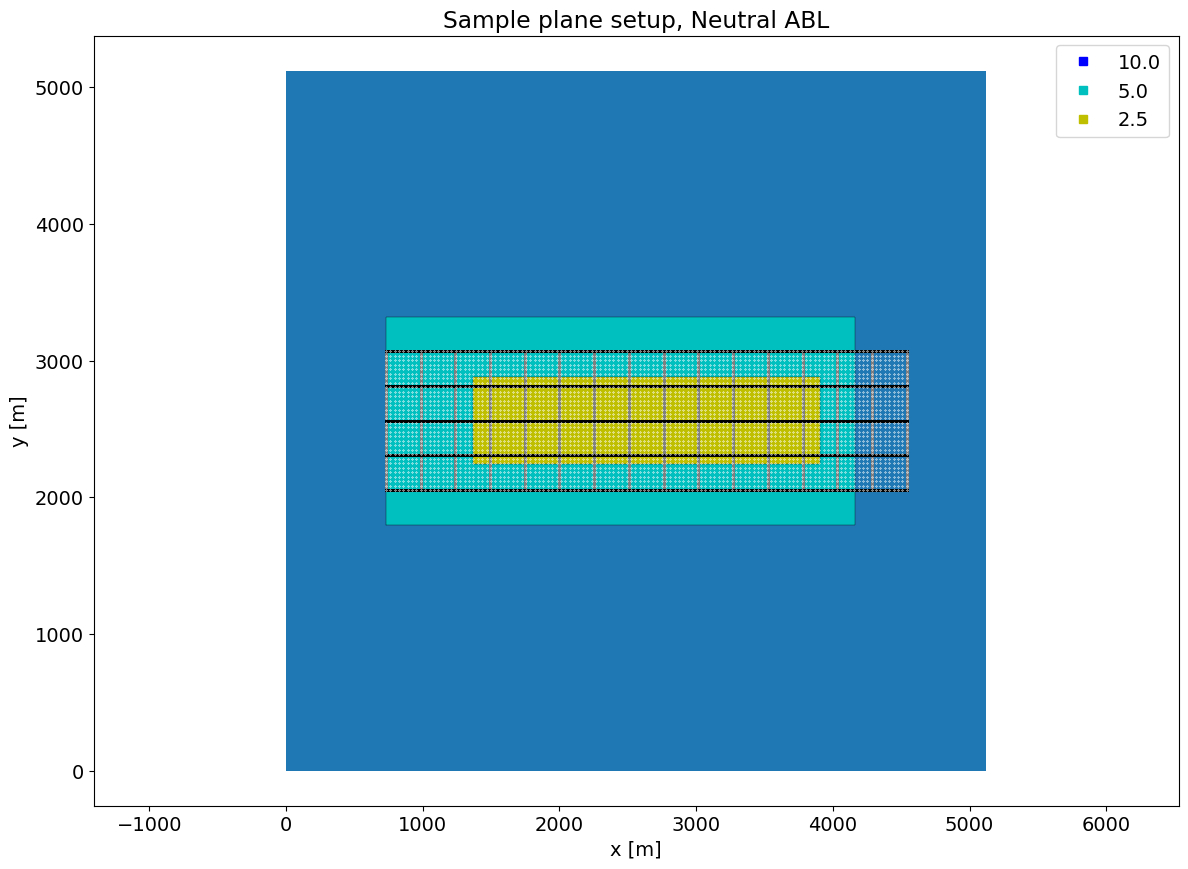

In [9]:
plt.figure(figsize=(14,10));
#fig, axs = plt.subplots(1,2,figsize=(14,7),sharey=False);
plt.rc('font', size=14)

norththeta = (180.0-270.0)*np.pi/180.0
northvec   = [-np.sin(norththeta), np.cos(norththeta)]

# Plot the background mesh
yamldata = plotmesh.getyamlfromstring(naluinput)
turbineXY, turbineD, turbineHH, orienttype, winddir, refineboxes = plotmesh.getPreprocess(yamldata)
plotmesh.plotmeshes(yamldata, turbineXY, turbineD, winddir, refineboxes, windarrowcenter=None, initlevel=1, plotturbs=False)

# Plot the individual turbine mesh
ilevel = len(refineboxes)
yamldata2= plotmesh.getyamlfromstring(naluturbines)
turbineXY2, turbineD, turbineHH, orienttype, winddir, refineboxes2 = plotmesh.getPreprocess(yamldata2)
#plotmesh.plotmeshes(yamldata2, turbineXY2, turbineD, winddir, refineboxes2, windarrowcenter=None, initlevel=ilevel+1)

# Plot the data_probes
# YZplanes
probesyaml = plotmesh.getyamlfromstring(probesyamlstring%allyzplanes)
plotmesh.plotRealms(probesyaml, color='gray', marker='.', markersize=0.5, linewidth=0)
# XZplanes
probesyaml = plotmesh.getyamlfromstring(probesyamlstring%allxzplanes)
plotmesh.plotRealms(probesyaml, color='k', marker='.', markersize=0.5, linewidth=0)
# XYplanes
probesyaml = plotmesh.getyamlfromstring(probesyamlstring%allxyplanesCOARSE)
plotmesh.plotRealms(probesyaml, color='white', marker='.', markersize=0.5, linewidth=0)

# Make a legend
legend_el = []
for i, level in enumerate(sizelevelsmin0): legend_el.append(Line2D([0],[0], linewidth=0, marker='s',color=colors[i], label=level[1][0]))
plt.legend(handles=legend_el, fontsize=14, frameon=True)

zoomin = False   # If True, zoom in on the turbines
if zoomin:
    plt.xlim([1800, 2200])
    plt.ylim([1800, 2200])
else:
    plt.axis('equal');

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Sample plane setup, Neutral ABL');

In [10]:
if savefiles:
    if len(sampleplanesavefile)>0:
        f=open(sampleplanesavefile,'w')
        f.write(allYAMLSamplePlanes)
        f.close()